In [1]:
import os
import cv2
import itertools
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import IsolationForest

import keras
from keras.utils import plot_model
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Input, Conv2D, MaxPool2D, Flatten, Dropout
from keras.utils import to_categorical
from keras.models import load_model
from keras.callbacks import ModelCheckpoint

**1. Image Processing**

In [2]:
def face_detection(img):
    img = img[70:195,78:172]
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, (50, 50))
    return img

def show_progress(val, val_len, folder, bar_size=20):
    progr = "#"*round((val)*bar_size/val_len) + " "*round((val_len - (val))*bar_size/val_len)
    if val == 0:
        print("", end = "\n")
    else:
        print("[%s] (%d samples)\t label: %s \t\t" % (progr, val+1, folder), end="\r")

In [3]:
dataset_folder = "/content/drive/MyDrive/dataset"

names = []
images = []
for folder in os.listdir(dataset_folder):
    # print(folder)
    files = os.listdir(os.path.join(dataset_folder, folder))[:150]
    # print(files)
    if len(files) < 50:
        continue
    for i, name in enumerate(files):
        if name.find(".jpg") > -1 :
            # Construct the full image path using os.path.join
            img_path = os.path.join(dataset_folder, folder, name)
            img = cv2.imread(img_path)
            # Check if image was loaded successfully
            if img is not None:
                img = face_detection(img) # detect face using mtcnn and crop to 100x100
                images.append(img)
                names.append(folder)
                show_progress(i, len(files), folder)
            else:
                print(f"Could not load image: {img_path}") # Print an error message if image loading fails

In [4]:
print("number of samples :", len(names))

number of samples : 1378


In [5]:
def img_augmentation(img):
    h, w = img.shape
    center = (w // 2, h // 2)
    M_rot_5 = cv2.getRotationMatrix2D(center, 5, 1.0)
    M_rot_neg_5 = cv2.getRotationMatrix2D(center, -5, 1.0)
    M_rot_10 = cv2.getRotationMatrix2D(center, 10, 1.0)
    M_rot_neg_10 = cv2.getRotationMatrix2D(center, -10, 1.0)
    M_trans_3 = np.float32([[1, 0, 3], [0, 1, 0]])
    M_trans_neg_3 = np.float32([[1, 0, -3], [0, 1, 0]])
    M_trans_6 = np.float32([[1, 0, 6], [0, 1, 0]])
    M_trans_neg_6 = np.float32([[1, 0, -6], [0, 1, 0]])
    M_trans_y3 = np.float32([[1, 0, 0], [0, 1, 3]])
    M_trans_neg_y3 = np.float32([[1, 0, 0], [0, 1, -3]])
    M_trans_y6 = np.float32([[1, 0, 0], [0, 1, 6]])
    M_trans_neg_y6 = np.float32([[1, 0, 0], [0, 1, -6]])

    imgs = []
    imgs.append(cv2.warpAffine(img, M_rot_5, (w, h), borderValue=(255,255,255)))
    imgs.append(cv2.warpAffine(img, M_rot_neg_5, (w, h), borderValue=(255,255,255)))
    imgs.append(cv2.warpAffine(img, M_rot_10, (w, h), borderValue=(255,255,255)))
    imgs.append(cv2.warpAffine(img, M_rot_neg_10, (w, h), borderValue=(255,255,255)))
    imgs.append(cv2.warpAffine(img, M_trans_3, (w, h), borderValue=(255,255,255)))
    imgs.append(cv2.warpAffine(img, M_trans_neg_3, (w, h), borderValue=(255,255,255)))
    imgs.append(cv2.warpAffine(img, M_trans_6, (w, h), borderValue=(255,255,255)))
    imgs.append(cv2.warpAffine(img, M_trans_neg_6, (w, h), borderValue=(255,255,255)))
    imgs.append(cv2.warpAffine(img, M_trans_y3, (w, h), borderValue=(255,255,255)))
    imgs.append(cv2.warpAffine(img, M_trans_neg_y3, (w, h), borderValue=(255,255,255)))
    imgs.append(cv2.warpAffine(img, M_trans_y6, (w, h), borderValue=(255,255,255)))
    imgs.append(cv2.warpAffine(img, M_trans_neg_y6, (w, h), borderValue=(255,255,255)))
    imgs.append(cv2.add(img, 10))
    imgs.append(cv2.add(img, 30))
    imgs.append(cv2.add(img, -10))
    imgs.append(cv2.add(img, -30))
    imgs.append(cv2.add(img, 15))
    imgs.append(cv2.add(img, 45))
    imgs.append(cv2.add(img, -15))
    imgs.append(cv2.add(img, -45))

    return imgs

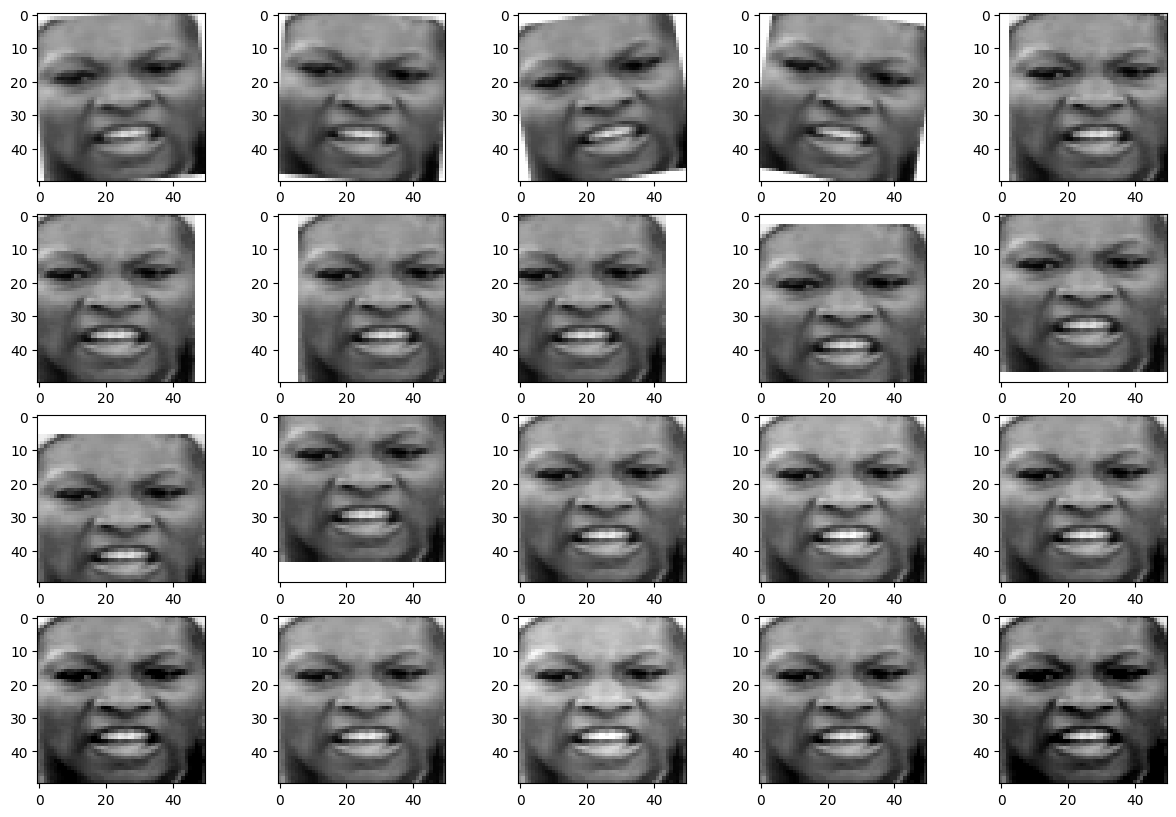

In [6]:
img_test = images[0]

augmented_image_test = img_augmentation(img_test)

plt.figure(figsize=(15,10))
for i, img in enumerate(augmented_image_test):
    plt.subplot(4,5,i+1)
    plt.imshow(img, cmap="gray")
plt.show()

In [7]:
augmented_images = []
augmented_names = []
for i, img in enumerate(images):
    try :
        augmented_images.extend(img_augmentation(img))
        augmented_names.extend([names[i]] * 20)
    except :
        print(i)

In [8]:
len(augmented_images), len(augmented_names)

(27560, 27560)

In [9]:
images.extend(augmented_images)
names.extend(augmented_names)

In [10]:
len(images), len(names)

(28938, 28938)

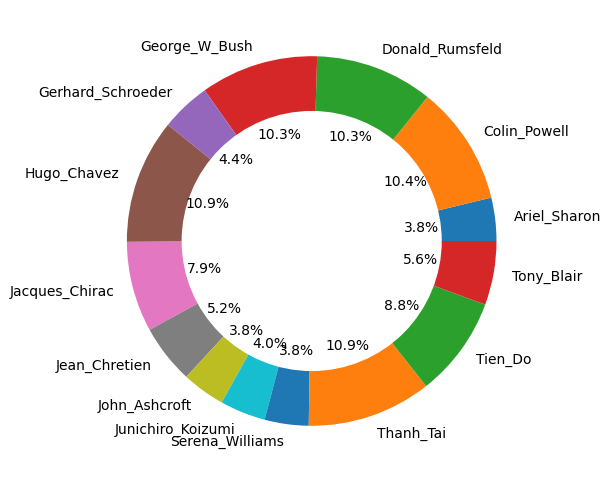

In [11]:
def print_data(label_distr, label_name):
    plt.figure(figsize=(12,6))

    my_circle = plt.Circle((0,0), 0.7, color='white')
    plt.pie(label_distr, labels=label_name, autopct='%1.1f%%')
    plt.gcf().gca().add_artist(my_circle)
    plt.show()

unique = np.unique(names)
label_distr = {i:names.count(i) for i in names}.values()
print_data(label_distr, unique)

In [12]:
n = 1000

def randc(labels, l):
    return np.random.choice(np.where(np.array(labels) == l)[0], n, replace=False)

mask = np.hstack([randc(names, l) for l in np.unique(names)])

In [13]:
names = [names[m] for m in mask]
images = [images[m] for m in mask]

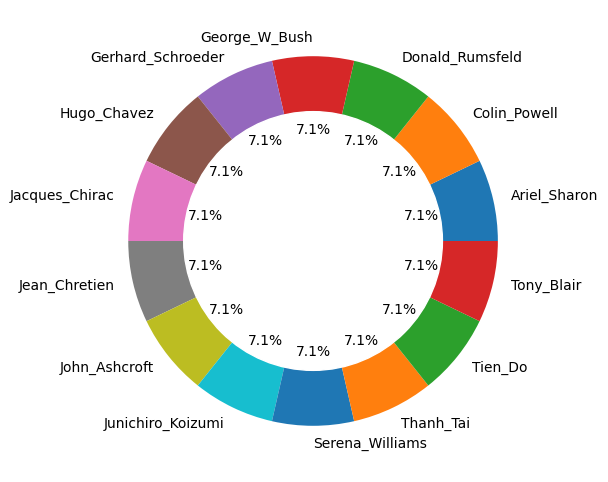

In [14]:
label_distr = {i:names.count(i) for i in names}.values()
print_data(label_distr, unique)

**2. Encoding Label**

In [15]:
le = LabelEncoder()
le.fit(names)
labels = le.classes_
name_vec = le.transform(names)
categorical_name_vec = to_categorical(name_vec)

In [16]:
print("Number of class :", len(labels))
print(labels)

Number of class : 14
['Ariel_Sharon' 'Colin_Powell' 'Donald_Rumsfeld' 'George_W_Bush'
 'Gerhard_Schroeder' 'Hugo_Chavez' 'Jacques_Chirac' 'Jean_Chretien'
 'John_Ashcroft' 'Junichiro_Koizumi' 'Serena_Williams' 'Thanh_Tai'
 'Tien_Do' 'Tony_Blair']


In [17]:
print(name_vec)

[ 0  0  0 ... 13 13 13]


In [18]:
print(categorical_name_vec)

[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]


**3. Split Dataset**

In [19]:
x_train, x_test, y_train, y_test = train_test_split(np.array(images, dtype=np.float32),   # input data
                                                    np.array(categorical_name_vec),       # target/output data
                                                    test_size=0.15,
                                                    random_state=42)

In [20]:
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(11900, 50, 50) (11900, 14) (2100, 50, 50) (2100, 14)


In [21]:
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)

In [22]:
x_train.shape, x_test.shape

((11900, 50, 50, 1), (2100, 50, 50, 1))

In [23]:
x_train_2d = x_train.reshape(x_train.shape[0], -1)
y_train_2d = y_train.reshape(y_train.shape[0], -1)
x_test_2d = x_test.reshape(x_test.shape[0], -1)
y_test_2d = y_test.reshape(y_test.shape[0], -1)
x_train_2d.shape, x_test_2d.shape

((11900, 2500), (2100, 2500))

In [24]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=13, random_state=42)
clf.fit(x_train_2d, y_train_2d)

RandomForestClassifier(n_estimators=13, random_state=42)

In [25]:
# Make predictions
preds = clf.predict(x_test_2d)

In [26]:
preds = clf.predict(x_test.reshape(x_test.shape[0], -1))
preds_binary = np.argmax(preds, axis=1)
y_test_binary = np.argmax(y_test, axis=1)
matrix = confusion_matrix(y_test_binary, preds_binary)

In [27]:
print(classification_report(y_test_binary, preds_binary, target_names=labels))

                   precision    recall  f1-score   support

     Ariel_Sharon       0.11      0.99      0.19       150
     Colin_Powell       1.00      0.09      0.16       147
  Donald_Rumsfeld       1.00      0.26      0.41       157
    George_W_Bush       1.00      0.08      0.14       142
Gerhard_Schroeder       1.00      0.09      0.16       148
      Hugo_Chavez       1.00      0.12      0.21       151
   Jacques_Chirac       1.00      0.27      0.42       162
    Jean_Chretien       1.00      0.28      0.44       144
    John_Ashcroft       1.00      0.30      0.46       156
Junichiro_Koizumi       0.96      0.45      0.61       159
  Serena_Williams       0.96      0.74      0.83       148
        Thanh_Tai       1.00      1.00      1.00       137
          Tien_Do       1.00      0.96      0.98       135
       Tony_Blair       1.00      0.07      0.14       164

         accuracy                           0.40      2100
        macro avg       0.93      0.41      0.44      

In [28]:
input_shape = x_train[0].shape

model = Sequential()

model.add(Conv2D(64, (3,3), padding="valid", activation="relu", input_shape=input_shape))
model.add(Conv2D(64, (3,3), padding="valid", activation="relu", input_shape=input_shape))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(128, (3,3), padding="valid", activation="relu"))
model.add(Conv2D(128, (3,3), padding="valid", activation="relu"))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

model.add(Flatten())

model.add(Dense(128, activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.25))
model.add(Dense(len(labels)))  # equal to number of classes
model.add(Activation("softmax"))

model.summary()

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics = ['accuracy'])

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 48, 48, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 46, 46, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 21, 21, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 19, 19, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 10368)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,327,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 14)             │           910 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 14)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,595,406 (6.09 MB)

 Trainable params: 1,595,406 (6.09 MB)

 Non-trainable params: 0 (0.00 B)

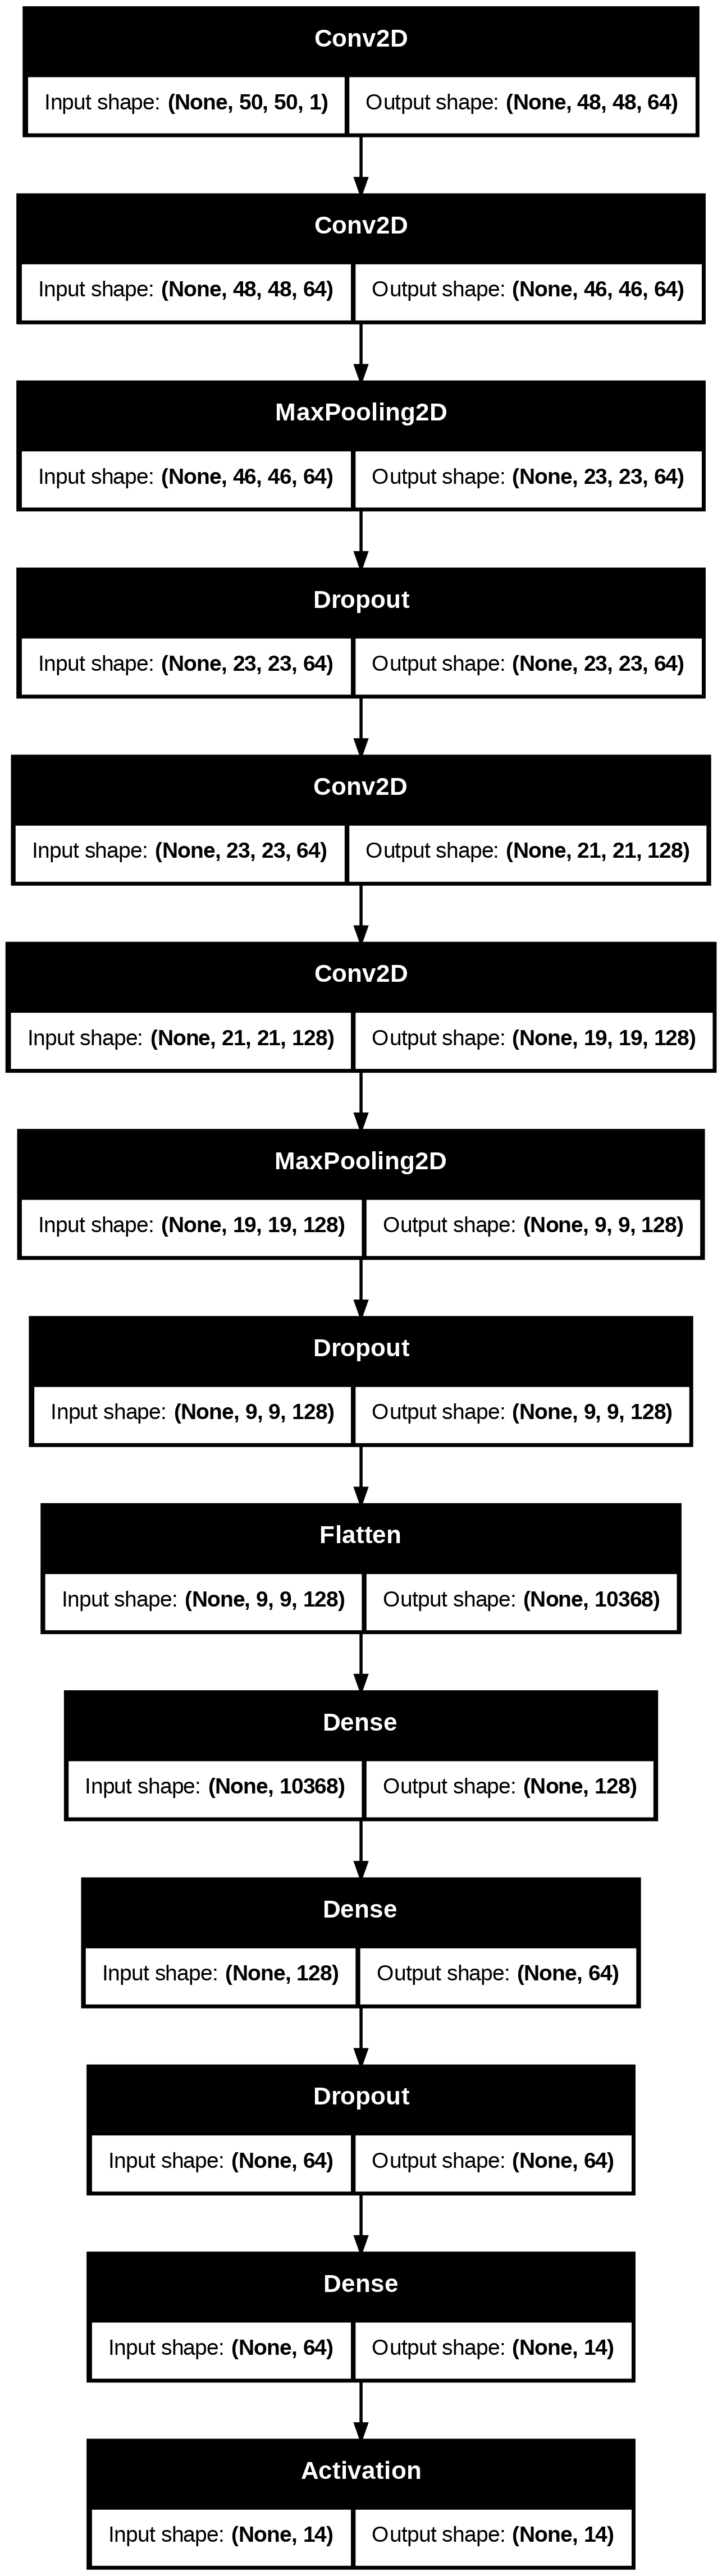

In [29]:
plot_model(model, show_shapes=True)

In [30]:
EPOCHS = 200
BATCH_SIZE = 32

check_point = ModelCheckpoint('/content/drive/MyDrive/Image Dataset/model_CNN.keras', monitor="val_accuracy", mode="max",
                              verbose=True, save_best_only=True)


history = model.fit(x_train,
                    y_train,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    shuffle=True,
                    validation_split=0.15,   # 15% of train dataset will be used as validation set
                    callbacks = [check_point])

Epoch 1/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.1627 - loss: 3.4601
Epoch 1: val_accuracy improved from -inf to 0.56639, saving model to /content/drive/MyDrive/Image Dataset/model_CNN.keras
317/317 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - accuracy: 0.1630 - loss: 3.4567 - val_accuracy: 0.5664 - val_loss: 1.3994
Epoch 2/200
308/317 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5430 - loss: 1.3764
Epoch 2: val_accuracy improved from 0.56639 to 0.81793, saving model to /content/drive/MyDrive/Image Dataset/model_CNN.keras
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5454 - loss: 1.3696 - val_accuracy: 0.8179 - val_loss: 0.5850
Epoch 3/200
315/317 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7643 - loss: 0.7224
Epoch 3: val_accuracy improved from 0.81793 to 0.89356, saving model to /content/drive/MyDrive/Image Dataset/model_CNN.keras
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7646 - loss: 0.7216 - val_accuracy: 0.8936 - val_loss: 0.3142
Epoch 4/200
3

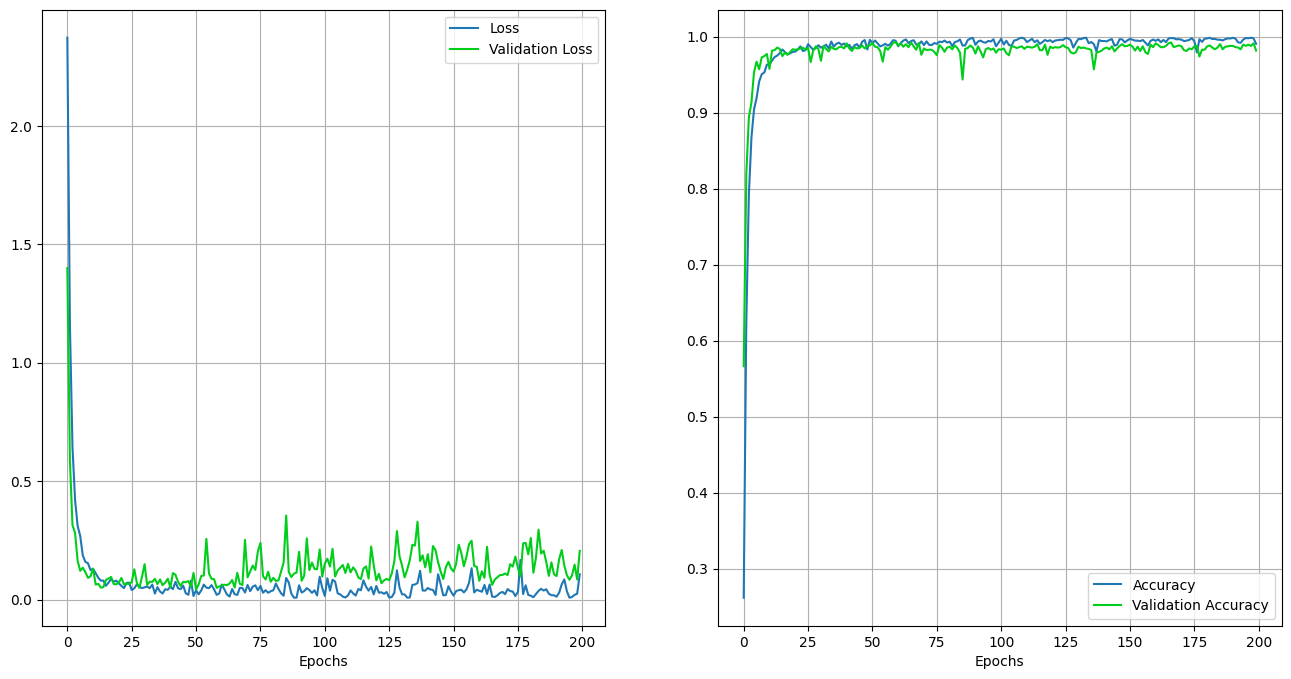

In [31]:
loss = history.history['loss']
validation_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
fig = plt.gcf()
fig.set_size_inches(16, 8)
plt.subplot(1,2,1)
plt.plot(loss)
plt.plot(validation_loss, color = "#01CE1B")
plt.xlabel("Epochs")
plt.legend(['Loss', 'Validation Loss'])
plt.grid()
plt.subplot(1,2,2)
plt.plot(accuracy)
plt.plot(val_accuracy, color = "#01CE1B")
plt.xlabel("Epochs")
plt.legend(['Accuracy', 'Validation Accuracy'])
plt.grid()
plt.show()

In [32]:
model.save("/content/drive/MyDrive/Image Dataset/model.keras")

In [33]:
y_pred=model.predict(x_test)

66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step


In [34]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(8, 8))

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

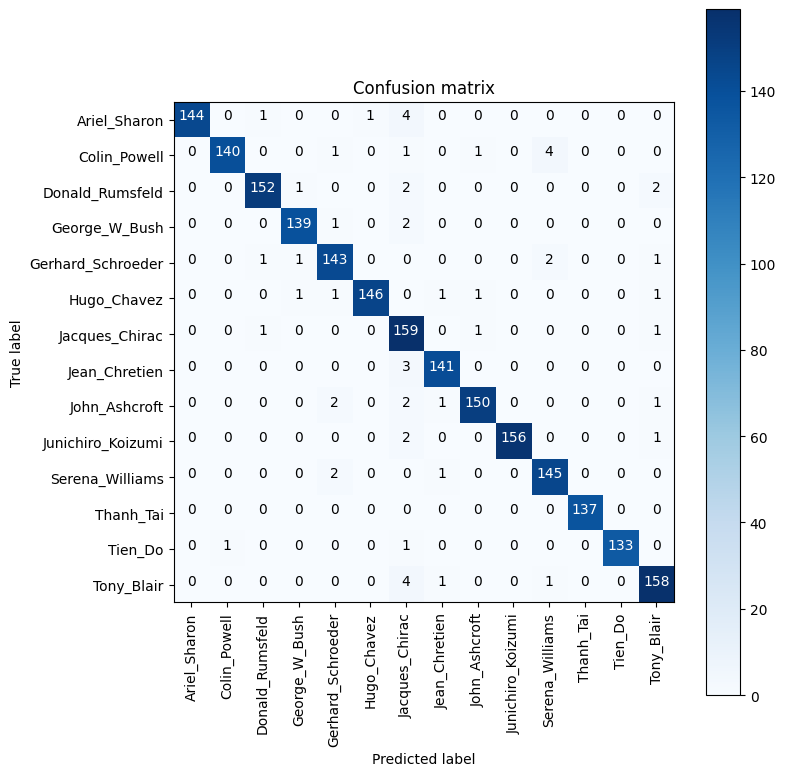

In [35]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(cnf_matrix, classes=labels,normalize=False,
                      title='Confusion matrix')

In [36]:
print(classification_report(y_test.argmax(axis=1),
                            y_pred.argmax(axis=1),
                            target_names=labels))

                   precision    recall  f1-score   support

     Ariel_Sharon       1.00      0.96      0.98       150
     Colin_Powell       0.99      0.95      0.97       147
  Donald_Rumsfeld       0.98      0.97      0.97       157
    George_W_Bush       0.98      0.98      0.98       142
Gerhard_Schroeder       0.95      0.97      0.96       148
      Hugo_Chavez       0.99      0.97      0.98       151
   Jacques_Chirac       0.88      0.98      0.93       162
    Jean_Chretien       0.97      0.98      0.98       144
    John_Ashcroft       0.98      0.96      0.97       156
Junichiro_Koizumi       1.00      0.98      0.99       159
  Serena_Williams       0.95      0.98      0.97       148
        Thanh_Tai       1.00      1.00      1.00       137
          Tien_Do       1.00      0.99      0.99       135
       Tony_Blair       0.96      0.96      0.96       164

         accuracy                           0.97      2100
        macro avg       0.97      0.97      0.97      

In [ ]:
def draw_ped(img, label, x0, y0, xt, yt, color=(255,127,0), text_color=(255,255,255)):

    (w, h), baseline = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
    # Rectangle face
    cv2.rectangle(img,
                  (x0, y0 + baseline),
                  (max(xt, x0 + w), yt),
                  color,
                  2)
    # Rectangle name
    cv2.rectangle(img,
                  (x0, y0 - h),
                  (x0 + w, y0 + baseline),
                  color,
                  -1)
    cv2.putText(img,
                label,
                (x0, y0),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.5,
                text_color,
                1,
                cv2.LINE_AA)
    return img

In [ ]:
labels = ['Ariel_Sharon', 'Colin_Powell', 'Donald_Rumsfeld', 'George_W_Bush', 'Gerhard_Schroeder',
          'Hugo_Chavez', 'Jacques_Chirac', 'Jean_Chretien', 'John_Ashcroft', 'Junichiro_Koizumi',
          'Serena_Williams', 'Tiendo2k1', 'Tony_Blair']

In [ ]:
# --------- load Haar Cascade model -------------
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_default.xml')

# --------- load Keras CNN model -------------
model = load_model("/content/drive/MyDrive/Image Dataset/model.keras")
print("[INFO] finish load model...")

cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    if ret:
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray, 1.1, 5)
        for (x, y, w, h) in faces:

            face_img = gray[y:y+h, x:x+w]
            face_img = cv2.resize(face_img, (50, 50))
            face_img = face_img.reshape(1, 50, 50, 1)

            result = model.predict(face_img)
            idx = result.argmax(axis=1)
            confidence = result.max(axis=1)*100
            if confidence > 90:
                label_text = "%s (%.2f %%)" % (labels[idx], confidence)
            else :
                label_text = "N/A"
            frame = draw_ped(frame, label_text, x, y, x + w, y + h, color=(0,255,255), text_color=(50,50,50))

        cv2.imshow('Detect Face', frame)
    else :
        break
    if cv2.waitKey(10) == ord('q'):
        break

cv2.destroyAllWindows()
cap.release()

[INFO] finish load model...
